In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import lib
np.random.seed(666)

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
# check lib.py

Load the image and rescale it in $[0,1]$

In [5]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

Extract a bunch of random patches from the image

In [6]:
npatch = 10000

S = lib.img_to_patches(img, p)
S = S[:, np.random.choice(S.shape[1], npatch)]
S.shape

(64, 10000)

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [7]:
S -= S.mean(axis=0)
S.shape, np.allclose(S.mean(axis=0), 0)

((64, 10000), True)

Initialize the dictionary and the coefficient matrix

In [8]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = S[:, np.random.choice(S.shape[1], N, replace=False)]

# normalize each column of D (zero mean and unit norm)
D = D - np.mean(D, axis=0, keepdims=True)
D = D / np.linalg.norm(D, axis=0, keepdims=True)

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))

Main KSVD loop


In [9]:
ksvd = lib.kSVD(
    sparsity=L,
    N=N,
    epsilon=1e-9,
    max_iter=max_iter,
    omp_mode=lib.MatchingPursuit.Mode.ORTHOGONAL,
    n_jobs=8
)

In [10]:
D, X = ksvd.fit(S)
D.shape, X.shape

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


((64, 256), (256, 10000))

Show the learned dictionary

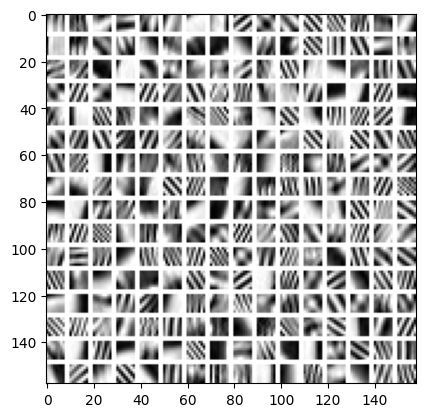

In [11]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray');